### Library Import

In [79]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

import altair as alt

import warnings
warnings.filterwarnings('ignore')


In [80]:
# load in test_train_split custom function
from train import test_train_split
from charts import line_chart

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [81]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file:
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl.pkl'), 'rb') as pickle_file:
    test_data = pickle.load(pickle_file)

Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [82]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)

U5 Images: 
---------------


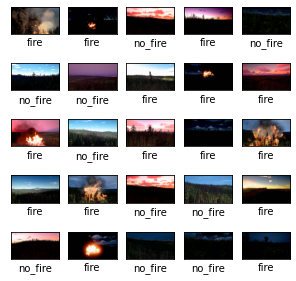

In [83]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = 5

    class_names = ['no_fire','fire']
    plt.figure(figsize=(5,5))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])

print('U5 Images: \n---------------')
plot_images(train_images, train_labels)

Test Real Images: 
---------------


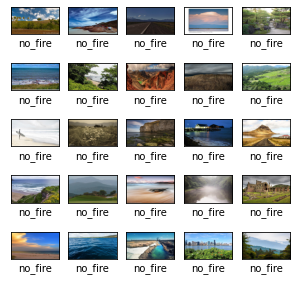

In [84]:
import random 
random.seed(42)
random.shuffle(test_data)
test_data_images, test_data_labels = zip(*test_data)
test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in test_data_images]
test_data_images = np.array(test_data_images)/255

print('Test Real Images: \n---------------')
plot_images(test_data_images, test_data_labels)

In [85]:
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0,653
1,1,863


In [86]:
df = pd.DataFrame([label[0] for label in test_data_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['test_data_label', 'count_of_label']
df

,test_data_label,count_of_label
0,0,4319
1,1,45


In [87]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]

# Image Agmentation and Sample Model 

In [88]:
# initial model with augment layer

augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 38s 726ms/step - loss: 0.6853 - accuracy: 0.6115 - val_loss: 0.5616 - val_accuracy: 0.6684
Epoch 2/10
48/48 [==============================] - 33s 686ms/step - loss: 0.5587 - accuracy: 0.6953 - val_loss: 0.4479 - val_accuracy: 0.8053
Epoch 3/10
48/48 [==============================] - 37s 768ms/step - loss: 0.4795 - accuracy: 0.7685 - val_loss: 0.4107 - val_accuracy: 0.8000
Epoch 4/10
48/48 [==============================] - 37s 761ms/step - loss: 0.4182 - accuracy: 0.7896 - val_loss: 0.3566 - val_accuracy: 0.8421
Epoch 5/10
48/48 [==============================] - 36s 751ms/step - loss: 0.4145 - accuracy: 0.7896 - val_loss: 0.3317 - val_accuracy: 0.8421
Epoch 6/10
48/48 [==============================] - 31s 638ms/step - loss: 0.3662 - accuracy: 0.8384 - val_loss: 0.2913 - val_accuracy: 0.8632
Epoch 7/10
48/48 [==============================] - 30s 622ms/step - loss: 0.3124 - accuracy: 0.8635 - val_loss: 0.2175 - val_accuracy: 0.9263

In [89]:
line_chart(history)

alt.Chart(...)

In [90]:
predictions = [model.predict(tf.expand_dims(img, 0)) for img in test_data_images[:50]]
scores = [tf.nn.softmax(prediction) for prediction in predictions]
pred_labels = [np.argmax(score) for score in scores]

In [91]:
true_labels = [i[0] for i in test_data_labels[:50]]

In [92]:
tf.math.confusion_matrix(true_labels, pred_labels[:50], 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 3, 47],
       [ 0,  0]], dtype=int32)>

In [93]:
#testing load model
model.save("artifacts/model.h5")
model = tf.keras.models.load_model('artifacts/model.h5')
width = model.input_shape[2]
height = model.input_shape[1]

print(width, height)

177 100


# Hyperparameter Tuning

In [99]:
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard
%reload_ext tensorboard
#! rm -rf ./logs/

In [100]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64])) #8
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'Nadam','RMSprop'])) #'sgd','Adagrad'

METRIC_ACCURACY = 'accuracy'

METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="loss (val.)",
    ),
    hp.Metric(
        "batch_accuracy",
        group="train",
        display_name="accuracy (train)",
    ),
    hp.Metric(
        "batch_loss",
        group="train",
        display_name="loss (train)",
    ),
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    metrics=METRICS
    )

In [102]:
# session_num = 0
# epochs = 50

# params = []
# losses = []
# accuracies = []
# f1_scores = []
# precisions = []
# recalls = []

# for num_units in HP_NUM_UNITS.domain.values:
#     for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#         for optimizer in HP_OPTIMIZER.domain.values:
# #             for metrics in METRICS:
#             hparams = {
#               HP_NUM_UNITS: num_units,
#               HP_DROPOUT: dropout_rate,
#               HP_OPTIMIZER: optimizer,
#             }
#             run_name = "run-%d" % session_num
#             print('--- Starting trial: %s' % run_name)
#             print({h.name: hparams[h] for h in hparams})
#             run('logs/hparam_tuning/' + run_name, hparams, epochs, augmentModel=True)
#             session_num += 1